# Data imp

In [2]:

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
original = pd.read_csv('../Data/podcast_dataset.csv')
df_subm = pd.read_csv('../Data/sample_submission.csv', index_col='id')
train = pd.read_csv('../Data/train.csv', index_col='id')
test = pd.read_csv('../Data/test.csv', index_col='id')


# Training Model

In [ ]:
train_eng = pd.read_csv('../Data/train_eng.csv', sep=';', encoding='utf-8')

In [77]:
X = train.drop(columns=['Listening_Time_minutes'])
y = train['Listening_Time_minutes']

In [ ]:
cv = KFold(5, random_state=42, shuffle=True)
y_pred = np.zeros(len(df_subm))

for idx_train, idx_valid in cv.split(X, y):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    X_test = test[X.columns].copy()
    
    encoded_columns = train.columns[12:]
    encoder = TargetEncoder(random_state=42)
    
    X_train[encoded_columns] = encoder.fit_transform(X_train[encoded_columns], y_train)
    X_valid[encoded_columns] = encoder.transform(X_valid[encoded_columns])
    X_test[encoded_columns] = encoder.transform(X_test[encoded_columns])

    model = XGBRegressor(
    device='cuda',
    enable_categorical=True,
    n_estimators=100,
    learning_rate=0.02,
    max_depth=11,
    subsample=0.8,
    colsample_bynode=0.6,
    random_state=42,
    verbosity=0,  # Standard-Regressionsziel: quadratischer Fehler
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
    )
    
    y_pred += model.predict(X_test)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

/var/folders/8p/zn111ygs1mq2_cx7q9m_3dmm0000gn/T/ipykernel_82538/3540132608.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[encoded_columns] = encoder.fit_transform(X_train[encoded_columns], y_train)
/var/folders/8p/zn111ygs1mq2_cx7q9m_3dmm0000gn/T/ipykernel_82538/3540132608.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[encoded_columns] = encoder.transform(X_valid[encoded_columns])


KeyboardInterrupt: 

In [56]:
encoder = TargetEncoder(random_state=42)
train[encoded_columns] = encoder.fit_transform(train[encoded_columns], train['Listening_Time_minutes'])
test[encoded_columns] = encoder.transform(test[encoded_columns])

In [67]:
np.random.seed(42)

features = [col for col in train.columns if col not in ['id', TARGET]]
X = train[features]
y = train['Listening_Time_minutes']

model = XGBRegressor(
    device='cuda',
    enable_categorical=True,
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=11,
    subsample=0.8,
    colsample_bynode=0.6,
    random_state=42,
    verbosity=0,  # Standard-Regressionsziel: quadratischer Fehler
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)

rmse_scores = np.sqrt(-cv_scores)

print("RMSE pro Fold:", rmse_scores)
print("Durchschnittlicher RMSE:", rmse_scores.mean())


RMSE pro Fold: [13.06555277 12.23592046 12.2429803  12.22823614 12.17773105]
Durchschnittlicher RMSE: 12.390084141417898


In [63]:
model.fit(X, y)
trained_model = model
test_features = test[features]
y_pred = model.predict(test_features)

In [62]:
result_df = pd.DataFrame({'id': test['id'], 'Listening_Time_minutes': y_pred})
model.save_model("../Submission/xgb_model.json")
result_df.to_csv('../Submission/xgb_feature_engineered.csv', index=False)

# Feature Engineering Playground

### One Hot Encode NAs

In [ ]:
guest_pop_na_mask = train['Guest_Popularity_percentage'].isna()
train['Guest_Popularity_NA'] = guest_pop_na_mask.astype(int)

if 'test' in locals() or 'test' in globals():
    test['Guest_Popularity_NA'] = test['Guest_Popularity_percentage'].isna().astype(int)

for col in ['Episode_Length_minutes', 'Number_of_Ads']:
    if train[col].isna().any():
        train[f'{col}_NA'] = train[col].isna().astype(int)
        if 'test' in locals() or 'test' in globals():
            test[f'{col}_NA'] = test[col].isna().astype(int)

Guest Popularity NA counts: 146028
Guest Popularity non-NA counts: 603916


### Target Encode every Col

In [ ]:
m = train[TARGET].mean()

ORIG_TARGET = []

for c in FEATURES:
    n = f"{c}2"
    ORIG_TARGET.append(n)  
    
    # Get target encoding mapping from original data
    target_mapping = original.groupby(c)[TARGET].mean()
    
    # Apply mapping to train and test
    if train[c].dtype.name == 'category':
        # For categorical columns, convert to string first
        train[n] = train[c].astype(str).map(target_mapping)
        test[n] = test[c].astype(str).map(target_mapping)
    else:
        # For non-categorical columns
        train[n] = train[c].map(target_mapping)
        test[n] = test[c].map(target_mapping)
    
    # Fill NA values
    train[n] = train[n].fillna(m)
    test[n] = test[n].fillna(m)

train.head(3)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Episode_Length_minutes2,Host_Popularity_percentage2,Guest_Popularity_percentage2,Number_of_Ads2,Podcast_Name2,Episode_Title2,Genre2,Publication_Day2,Publication_Time2,Episode_Sentiment2
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,...,45.436281,43.420073,45.436281,48.525459,46.143074,43.525145,46.551083,45.545049,45.902440,46.940936
1,1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,...,87.105517,43.957970,36.098898,44.321965,43.651926,45.260247,44.524182,45.194999,45.937834,44.654776
2,2,Study Sessions,Episode 16,73.9,Education,69.97,Tuesday,Evening,8.97,0.0,...,59.046850,39.812068,36.644250,48.525459,45.938614,44.309041,45.222056,46.273659,44.989281,44.654776


### Interaktion

In [ ]:
for col in CATS:
    combined = pd.concat([train[col], test[col]], axis=0)
    codes, uniques = pd.factorize(combined)
    train[col] = codes[:len(train)]
    test[col] = codes[len(train):]
    
# Define the selected interaction features based on my local forward selection:
SELECTED_INTERACT = [
    'Episode_Length_minutes_Host_Popularity_percentage', 
    'Episode_Length_minutes_Guest_Popularity_percentage', 
    'Episode_Length_minutes_Number_of_Ads', 
    'Episode_Length_minutes_Publication_Time', 
    'Episode_Length_minutes_Episode_Sentiment', 
    'Host_Popularity_percentage_Guest_Popularity_percentage', 
    'Host_Popularity_percentage_Number_of_Ads', 
    'Host_Popularity_percentage_Podcast_Name', 
    'Host_Popularity_percentage_Publication_Time', 
    'Host_Popularity_percentage_Episode_Sentiment', 
    'Guest_Popularity_percentage_Number_of_Ads', 
    'Guest_Popularity_percentage_Publication_Day', 
    'Guest_Popularity_percentage_Publication_Time', 
    'Guest_Popularity_percentage_Episode_Sentiment', 
    'Episode_Title_Episode_Sentiment'
]

# Create the selected interaction features for both train and test.
for candidate in SELECTED_INTERACT:
    c1, c2 = None, None
    for f in FEATURES:
        prefix = f + '_'
        if candidate.startswith(prefix):
            possible_c2 = candidate[len(prefix):]
            if possible_c2 in FEATURES:
                c1 = f
                c2 = possible_c2
                break
    if c1 is None or c2 is None:
        raise ValueError(f"Unable to parse the candidate feature '{candidate}' into two base features.")
    
    # Create the interaction feature as the product of the two columns.
    train[candidate] = train[c1] * train[c2]
    test[candidate] = test[c1] * test[c2]

print("Selected interaction features have been created in both train and test.")

Selected interaction features have been created in both train and test.


# Analytics (Feature Selection)

### Feature Importance

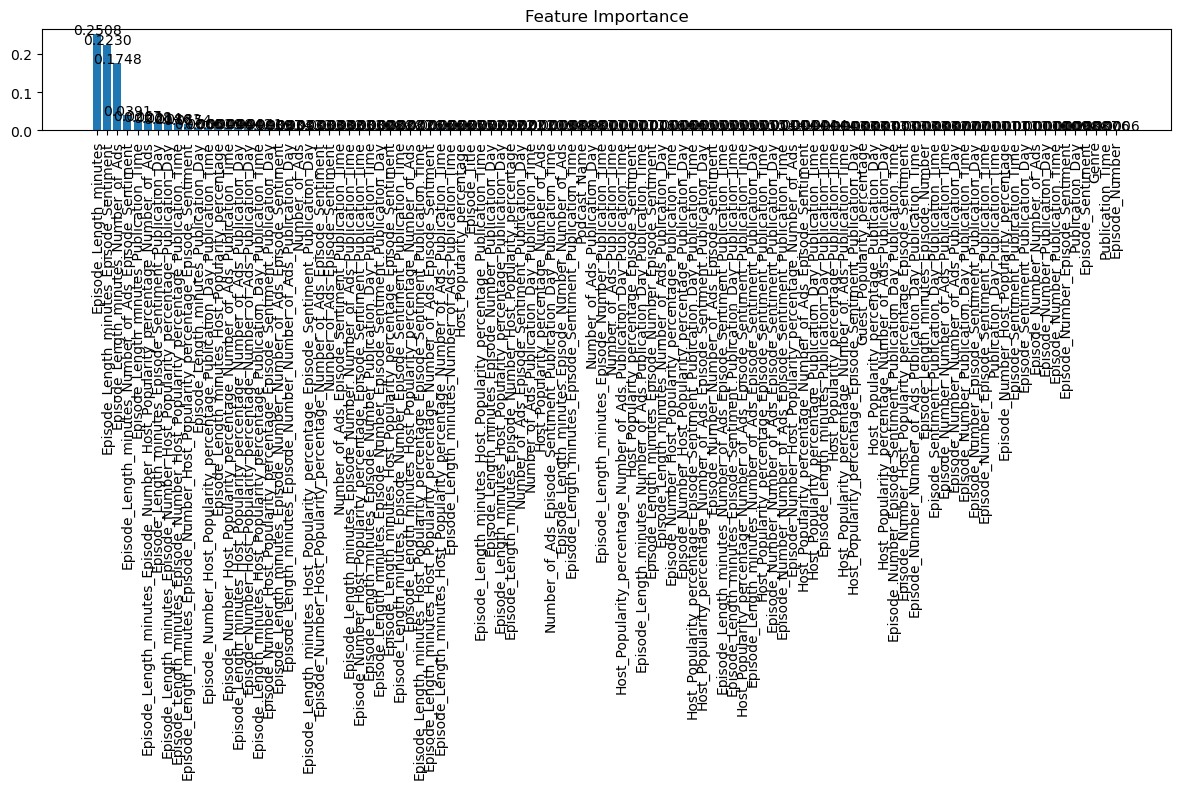


Feature Importance (Top 15):
Episode_Length_minutes                  : 0.2508
Episode_Length_minutes_Episode_Sentiment: 0.2230
Episode_Length_minutes_Number_of_Ads    : 0.1748
Episode_Length_minutes_Number_of_Ads_Episode_Sentiment: 0.0391
Episode_Length_minutes_Publication_Time : 0.0267
Episode_Length_minutes_Episode_Number_Host_Popularity_percentage_Number_of_Ads: 0.0238
Episode_Length_minutes_Episode_Sentiment_Publication_Day: 0.0214
Episode_Length_minutes_Episode_Number_Host_Popularity_percentage_Publication_Day: 0.0186
Episode_Length_minutes_Episode_Number_Host_Popularity_percentage_Publication_Time: 0.0183
Episode_Length_minutes_Episode_Number_Host_Popularity_percentage_Episode_Sentiment: 0.0154
Episode_Length_minutes_Publication_Day  : 0.0060
Episode_Number_Host_Popularity_percentage_Publication_Day_Publication_Time: 0.0051
Episode_Length_minutes_Host_Popularity_percentage: 0.0049
Episode_Number_Host_Popularity_percentage_Number_of_Ads_Publication_Time: 0.0046
Episode_Length_min

In [66]:
importance = model.feature_importances_
feature_names = features

# Sort features by importance
indices = np.argsort(importance)[::-1]
sorted_importance = importance[indices]
sorted_features = [feature_names[i] for i in indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.bar(range(len(sorted_importance)), sorted_importance, align='center')
plt.xticks(range(len(sorted_importance)), sorted_features, rotation=90)
plt.tight_layout()

# Adding values on top of bars
for i, v in enumerate(sorted_importance):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

plt.show()

# Print feature importance in tabular format
print("\nFeature Importance (Top 15):")
for i in range(min(15, len(sorted_features))):
    print(f"{sorted_features[i]:<40}: {sorted_importance[i]:.4f}")

### Forward Selection

In [28]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import KFold, cross_val_score

# Reproduzierbarkeit
np.random.seed(42)

# Exclude categorical columns that haven't been encoded yet and the target variable
excluded_cols = ['id', TARGET, 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Select numeric features only (target encoded and interaction features are already numeric)
features = [col for col in train.columns if col not in excluded_cols]
X = train[features]
y = train['Listening_Time_minutes']

# Definiere das Modell
model = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    n_estimators= 10,
    learning_rate=0.02,
    max_depth=11,
    subsample=0.8,
    colsample_bynode=0.6,
    random_state=42,
    verbosity=2,
    n_jobs=-1    
)

# KFold-Cross-Validation für stabile Schätzungen
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Forward Selection: Startet mit einem leeren Featureset und fügt in jedem Schritt das Feature hinzu,
# das den besten CV-Score erzielt.
sfs = SFS(model,
          k_features='best',  # Alternativ k_features kann auch eine Zahl sein, z.B. 10
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',  # Wir verwenden neg. MSE als Bewertungsmetrik
          cv=cv,
          n_jobs=1,
          verbose = 2)  # Serielle Ausführung um Pickling-Probleme zu vermeiden

# Fit des Selektors auf die Daten
sfs = sfs.fit(X, y)

# Zusammenfassung der ausgewählten Features
selected_features = list(sfs.k_feature_names_)
print("Ausgewählte Features:", selected_features)

# Optional: Bewertung der Modellgüte mit diesen Features
X_selected = sfs.transform(X)
scores = cross_val_score(model, X_selected, y, scoring='neg_mean_squared_error', cv=cv)
rmse_scores = np.sqrt(-scores)
print("RMSE Scores:", rmse_scores)
print("Durchschnittlicher RMSE:", rmse_scores.mean())


[2025-04-11 18:06:42] Features: 1/29 -- score: -552.288111532793
[2025-04-11 18:07:09] Features: 2/29 -- score: -552.3033942609097
[2025-04-11 18:07:38] Features: 3/29 -- score: -551.869933644696
[2025-04-11 18:08:15] Features: 4/29 -- score: -549.8751037242688
[2025-04-11 18:08:57] Features: 5/29 -- score: -549.4707000918685
[2025-04-11 18:09:38] Features: 6/29 -- score: -549.4557297594808
[2025-04-11 18:10:22] Features: 7/29 -- score: -549.2983823006032
[2025-04-11 18:11:07] Features: 8/29 -- score: -549.360444208417
[2025-04-11 18:11:53] Features: 9/29 -- score: -549.2787063236754
[2025-04-11 18:12:41] Features: 10/29 -- score: -549.2629423560954
[2025-04-11 18:13:31] Features: 11/29 -- score: -549.2631847873274
[2025-04-11 18:14:20] Features: 12/29 -- score: -549.2503475029613
[2025-04-11 18:15:08] Features: 13/29 -- score: -549.2727447098348
[2025-04-11 18:15:57] Features: 14/29 -- score: -549.2573225179156
[2025-04-11 18:16:44] Features: 15/29 -- score: -549.1945396356457
[2025-

Ausgewählte Features: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Length_minutes2', 'Host_Popularity_percentage2', 'Guest_Popularity_percentage2', 'Episode_Title2', 'Genre2', 'Publication_Day2', 'Episode_Sentiment2', 'Episode_Length_minutes_Number_of_Ads', 'Host_Popularity_percentage_Number_of_Ads', 'Guest_Popularity_percentage_Number_of_Ads', 'Guest_Popularity_percentage_Publication_Day']
RMSE Scores: [23.51341808 23.42873451 23.45161691 23.3995327  23.38097092]
Durchschnittlicher RMSE: 23.434854624850317
